# Manhattan Plots

In [1]:
import os

from adjustText import adjust_text
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import seaborn as sns
sns.set(rc={'font.sans-serif':'Helvetica'})
sns.set(style='whitegrid', rc={'font.sans-serif':'Helvetica'})

from IPython.display import display, HTML

%matplotlib inline

In [2]:
phenos = pd.read_table('../../h2-estimation/data/traits.tsv', index_col=0)
phenos = phenos[phenos.phenotype.isnull() == False]

In [3]:
chrom_sizes = pd.Series(
    {1: 249250621,
     10: 135534747,
     11: 135006516,
     12: 133851895,
     13: 115169878,
     14: 107349540,
     15: 102531392,
     16: 90354753,
     17: 81195210,
     18: 78077248,
     19: 59128983,
     2: 243199373,
     20: 63025520,
     21: 48129895,
     22: 51304566,
     3: 198022430,
     4: 191154276,
     5: 180915260,
     6: 171115067,
     7: 159138663,
     8: 146364022,
     9: 141213431,
    }
)
chrom_sizes_norm = chrom_sizes / chrom_sizes.max()

In [4]:
def read_results(fn):
    res = pd.read_csv(fn).drop_duplicates()
    res = res.sort_values(by=['chrom', 'pos'])
    vc = res.gene.value_counts()
    vc = vc[vc == 1]
    res = res[res.gene.isin(vc.index)]
    res.index = res.gene
    if 'CTD-3064M3.3' in res.index:
        res = res.drop('CTD-3064M3.3')
    if 'ZFAT-AS1' in res.index:
        res = res.drop('ZFAT-AS1')
    return(res)

In [5]:
def plot_manhattan(fn, ax):
    res = read_results(fn)
    # Assign x coordinates for each association.
    res['xpos'] = np.nan
    chrom_vc = res['chrom'].value_counts()
    # total_length is arbitrary, but it's a little easier than working with the 
    # normalize chromosome sizes to avoid small numbers.
    total_length = 1000
    right = chrom_sizes_norm.cumsum()
    right = right / right[22] * total_length
    left = chrom_sizes_norm.cumsum() - chrom_sizes_norm[1]
    left = pd.Series(0, range(1, 23))
    left[1:23] = right[0:21].values
    for chrom in range(1, 23):
        res.loc[res['chrom'] == chrom, 'xpos'] = np.linspace(
            left[chrom], right[chrom], chrom_vc[chrom])
    # Assign colors.
    grey = mpl.colors.to_rgb('grey')
    light_grey = (0.9, 0.9, 0.9)
    middle_grey = (0.8, 0.8, 0.8)
    res['color'] = 'black'
    for chrom in range(1, 23)[0::2]:
        ind = res[(res['l10bf'] < 2) & (res['chrom'] == chrom)].index
        res.loc[ind, 'color'] = pd.Series([grey for x in ind], index=ind)
    for chrom in range(1, 23)[1::2]:
        ind = res[(res['l10bf'] < 2) & (res['chrom'] == chrom)].index
        res.loc[ind, 'color'] = pd.Series([middle_grey for x in ind], index=ind)
    for chrom in range(1, 23):
        ind = res[(res['l10bf'] >= 2) & (res['l10bf'] < 3) & (res['chrom'] == chrom)].index
        res.loc[ind, 'color'] = pd.Series([sns.color_palette()[0] for x in ind], index=ind)
        ind = res[(res['l10bf'] >= 3) & (res['chrom'] == chrom)].index
        res.loc[ind, 'color'] = pd.Series([sns.color_palette()[1] for x in ind], index=ind)
    
    # Plot
    labels = ['$\log_{10}$ BF < 2', '$2 \leq \log_{10}$ BF < 3', '$\log_{10}$ BF > 3']
    for i,ind in enumerate([
        res[res['l10bf'] < 2].index,
        res[(res['l10bf'] >= 2) & (res['l10bf'] < 3)].index,
        res[(res['l10bf'] >= 3)].index,
    ]):
        ax.scatter(
            res.loc[ind, 'xpos'], 
            res.loc[ind, 'l10bf'], 
            color=res.loc[ind, 'color'], 
            s=15, 
            alpha=0.75,
            rasterized=True,
            label=labels[i],
        )
    ax.grid(axis='x')
    ax.grid(axis='y')
    ax.grid(axis='y', alpha=0.5, ls='--')
    # for chrom in range(1, 23)[0::2]:
    #     ax.axvspan(left[chrom], right[chrom], facecolor=(0.4, 0.4, 0.4), alpha=0.2, lw=0)
    ax.set_xlim(-5, total_length + 5)
    ymin,ymax = ax.get_ylim()
    ax.set_ylim(-5, ymax)
    # Set chromosome labels
    ind = range(1, 23)[0::2]
    ax.set_xticks(left[ind] + (right[ind] - left[ind]) / 2)
    ax.set_xticklabels(ind, fontsize=8)
    ax.set_ylabel('$\log_{10}$ Bayes Factor', fontsize=8)
    for t in ax.get_xticklabels() + ax.get_yticklabels():
        t.set_fontsize(8)
    ax.legend(fontsize=7, framealpha=0.5, frameon=True, facecolor='white', 
              loc='upper left')
    return(ax, res)

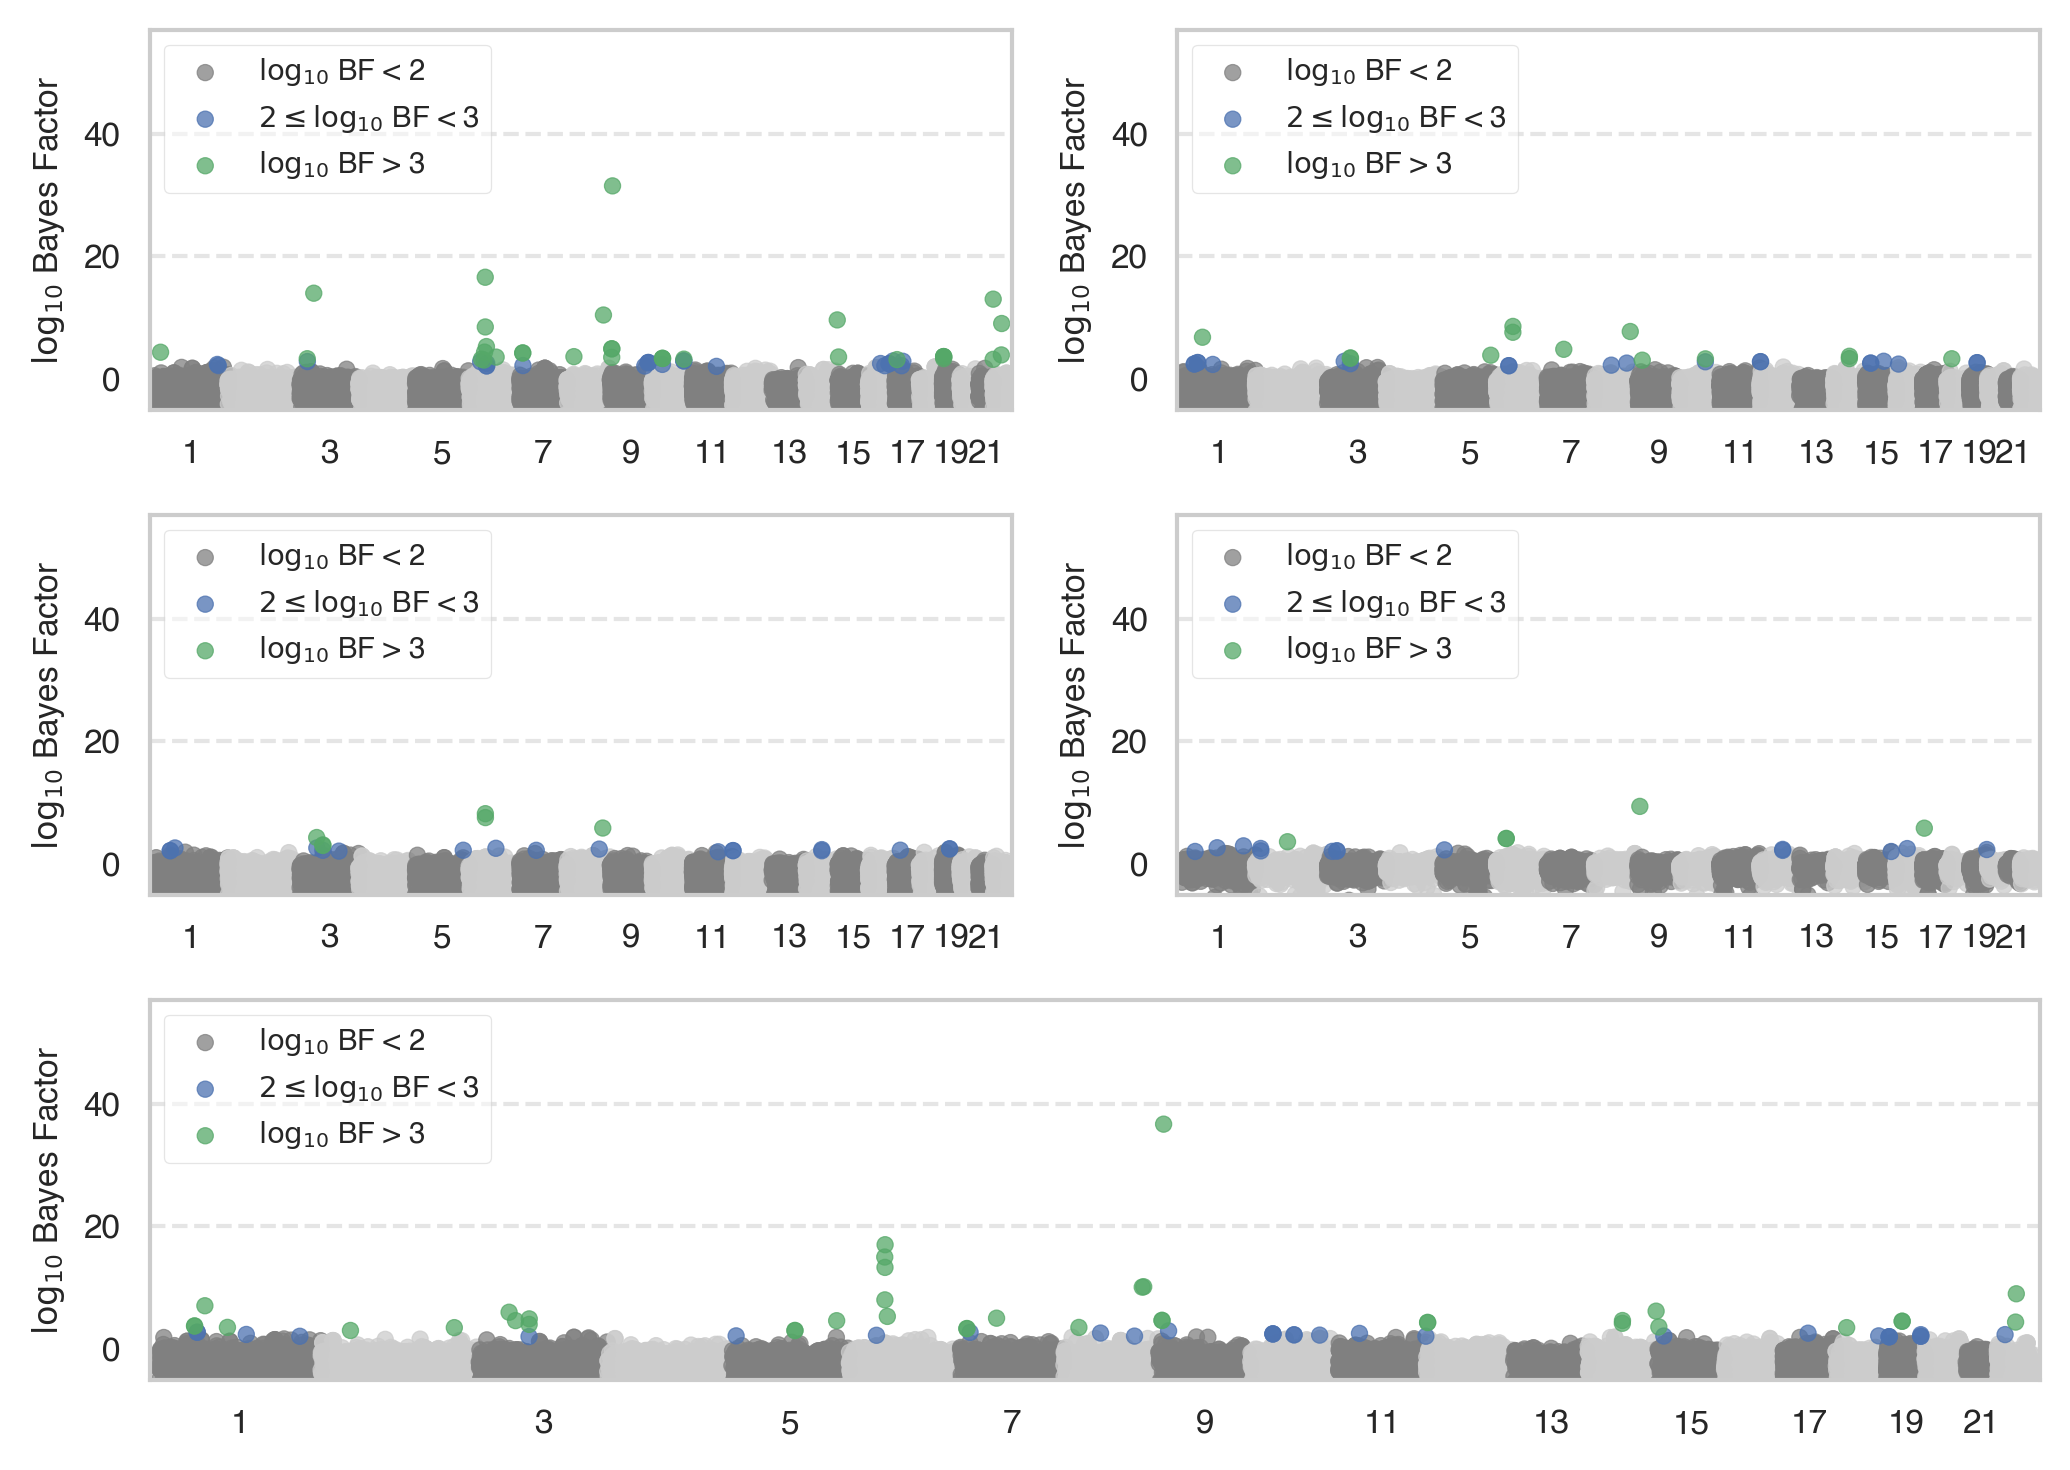

In [6]:
fig = plt.figure(figsize=(7, 5), dpi=300)
# gs = gridspec.GridSpec(1, 1)
# ax = fig.add_subplot(gs[0, 0])
# ax.text(0, 1, 'Figure 2',
#         size=14, va='top')
# clean_axis(ax)
# gs.tight_layout(fig, rect=[0, 0.93, 1, 1])

gs = gridspec.GridSpec(3, 2)
axs = []
ax = fig.add_subplot(gs[0, 0])
fn = '../results/INI30150.chrpos.01_00001.out'
ax,res = plot_manhattan(fn, ax)
axs.append(ax)

ax = fig.add_subplot(gs[0, 1])
fn = '../results/INI3062.chrpos.01_00001.out'
ax,res = plot_manhattan(fn, ax)
axs.append(ax)

ax = fig.add_subplot(gs[1, 0])
fn = '../results/INI3063.chrpos.01_00001.out'
ax,res = plot_manhattan(fn, ax)
axs.append(ax)

ax = fig.add_subplot(gs[1, 1])
fn = '../results/HC382.chrpos.01_00001.out'
ax,res = plot_manhattan(fn, ax)
axs.append(ax)

ax = fig.add_subplot(gs[2, 0:2])
fn = '../results/f4traits.chrpos.01_00001.out'
ax,res = plot_manhattan(fn, ax)
ymin,ymax = ax.get_ylim()
for a in axs:
    a.set_ylim(ymin, ymax)

gs.tight_layout(fig, rect=[0, 0, 1, 1])
plt.savefig('manhattan.pdf')

In [7]:
def get_annotations(fn):
    res = read_results(fn)
    tdf = res.sort_values(by='l10bf', ascending=False).drop_duplicates(subset=['gene'])
    tdf = tdf[tdf.chrom != 6].head(4)
    return(tdf.index)

annotations = dict()

for fn in [
    '../results/INI30150.chrpos.01_00001.out',
    '../results/INI3062.chrpos.01_00001.out',
    '../results/INI3063.chrpos.01_00001.out',
    '../results/HC382.chrpos.01_00001.out',
    '../results/f4traits.chrpos.01_00001.out',
]:
    annotations[fn] = get_annotations(fn)

I tried to use `adjust_text` to automatically adjust the text, but it wasn't working
so I just defined offsets for each label manually by plotting with a fixed offset
and then looking at each label to see which direction it needed to move.

In [8]:
def add_annotations(fn, ax, offsets):
    for i in annotations[fn]:
        if i in offsets.keys():
            offset = offsets[i]
        else:
            offset = (10, 10)
        ax.annotate(
            res.loc[i, 'gene'], 
            xy=(res.loc[i, 'xpos'], res.loc[i, 'l10bf']),
            xycoords='data',
            xytext=offset,
            textcoords='offset points',
            fontsize=7,
            style='italic',
            arrowprops=dict(
                arrowstyle='simple', 
                facecolor='black', 
                edgecolor='black',
                alpha=0.25, 
                shrinkB=3,
            )
        )
    return(ax)

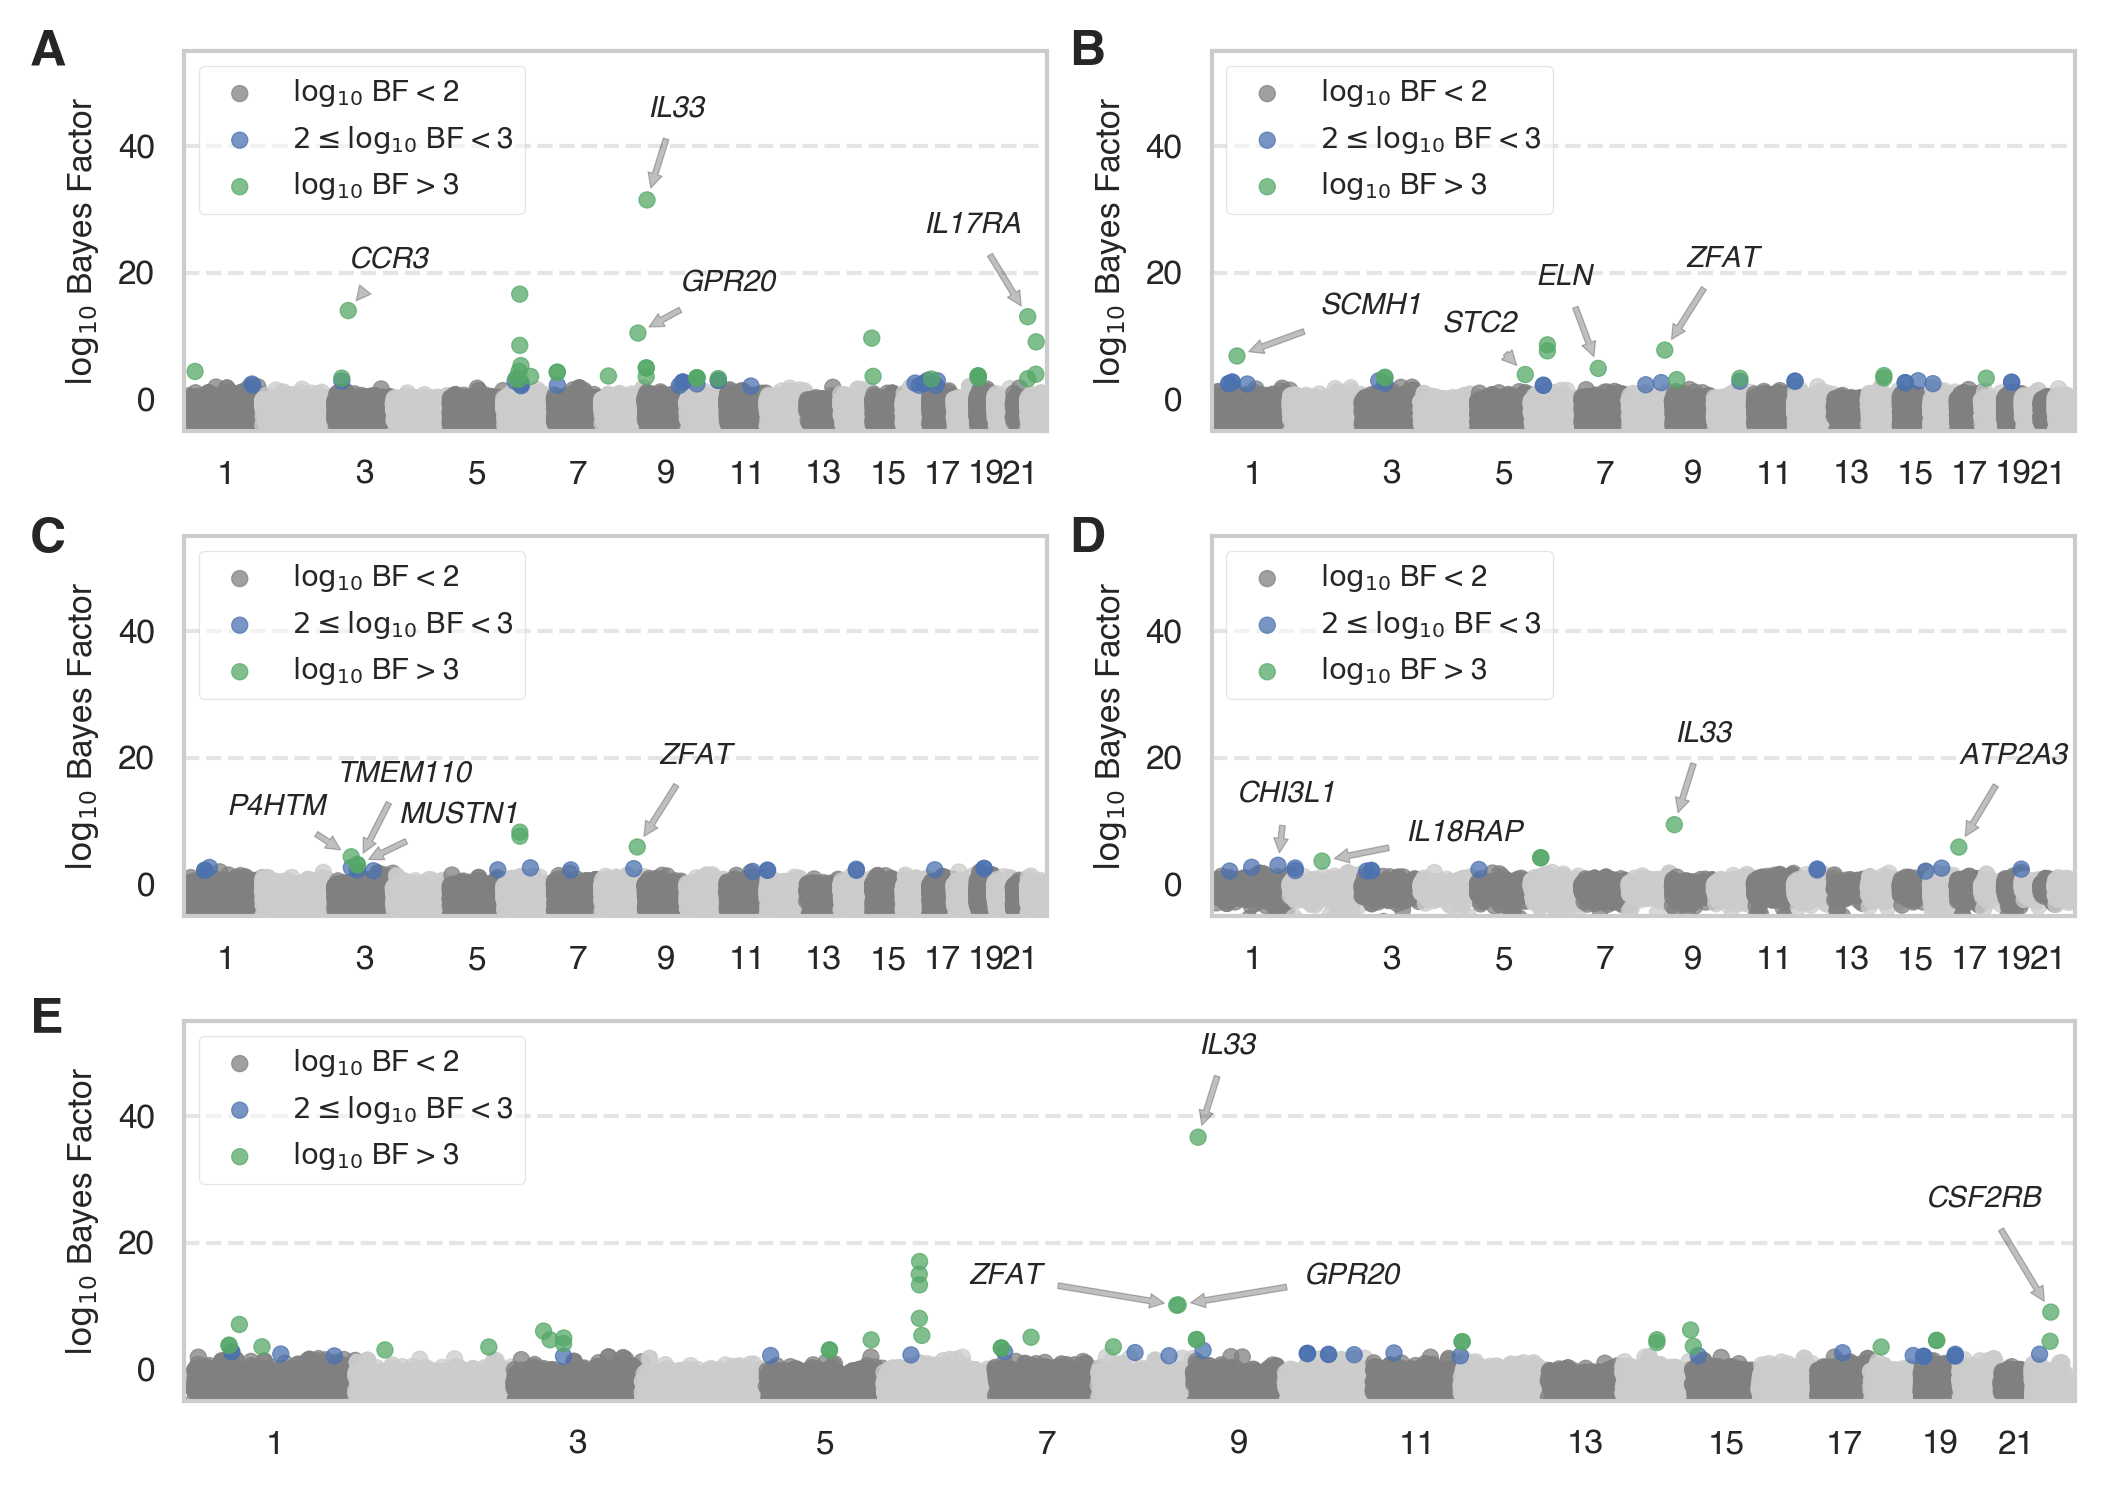

In [9]:
fig = plt.figure(figsize=(7, 5), dpi=300)
# gs = gridspec.GridSpec(1, 1)
# ax = fig.add_subplot(gs[0, 0])
# ax.text(0, 1, 'Figure 2',
#         size=14, va='top')
# clean_axis(ax)
# gs.tight_layout(fig, rect=[0, 0.93, 1, 1])

gs = gridspec.GridSpec(3, 2)
axs = []
ax = fig.add_subplot(gs[0, 0])
fn = '../results/INI30150.chrpos.01_00001.out'
ax,res = plot_manhattan(fn, ax)
ax.set_ylim(-5, 55)
offsets = {'IL33':(0, 20), 'CCR3':(0, 10), 'IL17RA':(-25, 20), 'CTD-3064M3.3':(0, 20)}
add_annotations(fn, ax, offsets)
axs.append(ax)

ax = fig.add_subplot(gs[0, 1])
fn = '../results/INI3062.chrpos.01_00001.out'
ax,res = plot_manhattan(fn, ax)
ax.set_ylim(-5, 55)
offsets = {'ZFAT':(5, 20), 'SCMH1':(20, 10), 'STC2':(-20, 10), 'ELN':(-15, 20)}
add_annotations(fn, ax, offsets)
axs.append(ax)

ax = fig.add_subplot(gs[1, 0])
fn = '../results/INI3063.chrpos.01_00001.out'
ax,res = plot_manhattan(fn, ax)
ax.set_ylim(-5, 55)
offsets = {'ZFAT':(5, 20), 'P4HTM':(-30, 10), 'ZFAT-AS1':(20, 10), 'TMEM110':(-5, 20)}
add_annotations(fn, ax, offsets)
axs.append(ax)

ax = fig.add_subplot(gs[1, 1])
fn = '../results/HC382.chrpos.01_00001.out'
ax,res = plot_manhattan(fn, ax)
ax.set_ylim(-5, 55)
offsets = {'IL33':(0, 20), 'ATP2A3':(0, 20), 'IL18RAP':(20, 5), 'CHI3L1':(-10, 15)}
add_annotations(fn, ax, offsets)
axs.append(ax)

ax = fig.add_subplot(gs[2, 0:2])
fn = '../results/f4traits.chrpos.01_00001.out'
ax,res = plot_manhattan(fn, ax)
ax.set_ylim(-5, 55)
# ymin,ymax = ax.get_ylim()
# for a in axs:
#     a.set_ylim(ymin, ymax)
offsets = {'IL33':(0, 20), 'ZFAT':(-50, 5), 'CSF2RB':(-30, 25), 'GPR20':(30, 5)}
add_annotations(fn, ax, offsets)

t = fig.text(0.005, 0.96, 'A', weight='bold', 
             size=12)
t = fig.text(0.5, 0.96, 'B', weight='bold', 
             size=12)
t = fig.text(0.005, 0.635, 'C', weight='bold', 
             size=12)
t = fig.text(0.5, 0.635, 'D', weight='bold', 
             size=12)
t = fig.text(0.005, 0.315, 'E', weight='bold', 
             size=12)

gs.tight_layout(fig, rect=[0, 0, 1, 1])
plt.savefig('manhattan.pdf')

In [10]:
results = dict()

fn = '../results/INI30150.chrpos.01_00001.out'
tdf = read_results(fn)
tdf = tdf.sort_values(by='l10bf', ascending=False)
results['INI30150'] = tdf

fn = '../results/INI3062.chrpos.01_00001.out'
tdf = read_results(fn)
tdf = tdf.sort_values(by='l10bf', ascending=False)
results['INI3062'] = tdf

fn = '../results/INI3063.chrpos.01_00001.out'
tdf = read_results(fn)
tdf = tdf.sort_values(by='l10bf', ascending=False)
results['INI3063'] = tdf

fn = '../results/HC382.chrpos.01_00001.out'
tdf = read_results(fn)
tdf = tdf.sort_values(by='l10bf', ascending=False)
results['HC382'] = tdf

fn = '../results/f4traits.chrpos.01_00001.out'
tdf = read_results(fn)
tdf = tdf.sort_values(by='l10bf', ascending=False)
results['f4'] = tdf

results_pd = pd.Panel(results)

In [11]:
table_index = tdf[(tdf['l10bf'] > 5) & (tdf['chrom'] != 6)].index
table = results_pd.loc[:, table_index, 'l10bf'].fillna(1000).round(1).astype(str).replace('1000.0', '')
cols = ['Asthma', 'Eosinophil count', 'FVC', 'FEV1', 'Joint']
table.columns = cols
table = table[['Joint', 'Eosinophil count', 'FVC', 'FEV1', 'Asthma']]
print(table)

       Joint Eosinophil count   FVC  FEV1 Asthma
gene                                            
IL33    36.6             31.5  -2.3  -1.9    9.4
GPR20   10.2             10.4  -0.1  -0.2       
ZFAT    10.1             -3.1   7.8   5.9   -0.5
CSF2RB   9.0              9.1   0.2  -0.1   -0.2
SCMH1    7.1             -1.5   6.8   2.6   -0.9
PACS2    6.2              9.6  -1.3  -1.6   -0.5
CCR3     6.0             14.0  -3.3  -3.7   -1.0
ELN      5.0             -1.5   4.9   2.3   -0.6


In [13]:
print(table.to_latex())

\begin{tabular}{llllll}
\toprule
{} & Joint & Eosinophil count &   FVC &  FEV1 & Asthma \\
gene   &       &                  &       &       &        \\
\midrule
IL33   &  36.6 &             31.5 &  -2.3 &  -1.9 &    9.4 \\
GPR20  &  10.2 &             10.4 &  -0.1 &  -0.2 &        \\
ZFAT   &  10.1 &             -3.1 &   7.8 &   5.9 &   -0.5 \\
CSF2RB &   9.0 &              9.1 &   0.2 &  -0.1 &   -0.2 \\
SCMH1  &   7.1 &             -1.5 &   6.8 &   2.6 &   -0.9 \\
PACS2  &   6.2 &              9.6 &  -1.3 &  -1.6 &   -0.5 \\
CCR3   &   6.0 &             14.0 &  -3.3 &  -3.7 &   -1.0 \\
ELN    &   5.0 &             -1.5 &   4.9 &   2.3 &   -0.6 \\
\bottomrule
\end{tabular}

